In [1]:
!pip install datasets

In [2]:
!pip install huggingface_hub

In [3]:
# OS
import io
import os
import glob
import shutil
import random

# 데이터셋 불러오고 확인용
import datasets
from datasets import load_dataset
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import cv2
from pprint import pprint

# 이미지/데이터분포 및 그래프로 시각화 확인용
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝
from sklearn.model_selection import train_test_split, StratifiedKFold

# tf와 케라스
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Input, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization,Add,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LeakyReLU, ReLU, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, UpSampling2D, concatenate
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K

In [4]:
dataset = load_dataset("nateraw/pascal-voc-2012",split='train')

Using custom data configuration nateraw___pascal-voc-2012-c68607404d4811ac
Reusing dataset parquet (/aiffel/.cache/huggingface/datasets/parquet/nateraw___pascal-voc-2012-c68607404d4811ac/0.0.0/9296ce43568b20d72ff8ff8ecbc821a16b68e9b8b7058805ef11f06e035f911a)


/tmp/ipykernel_105/32598191.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  encoded_img = np.fromstring(dataset['image'][0]['bytes'], dtype = np.uint8)
/tmp/ipykernel_105/32598191.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  encoded_img2 = np.fromstring(dataset['mask'][0]['bytes'], dtype = np.uint8)


[208 193 131]


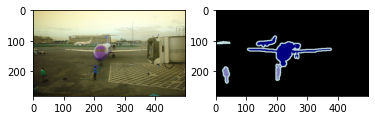

In [5]:
encoded_img = np.fromstring(dataset['image'][0]['bytes'], dtype = np.uint8)
img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
print(img[0,0])
plt.subplot(121)
plt.imshow(img)

encoded_img2 = np.fromstring(dataset['mask'][0]['bytes'], dtype = np.uint8)
img2 = cv2.imdecode(encoded_img2, cv2.IMREAD_COLOR)
plt.subplot(122)
plt.imshow(img2)
plt.show()

In [6]:
print(len(dataset))
print(len(dataset)*0.8)

train_data = dataset[:2330]
print("train_data[image] 크기: ", len(train_data['image']))
print("train_data[mask] 크기: ",len(train_data['mask']))
print(len(train_data))

test_data = dataset[2330:]
print("test_data[image] 크기: ",len(test_data['image']))
print("test_data[mask] 크기: ",len(test_data['mask']))
print(len(test_data))

2913
2330.4
train_data[image] 크기:  2330
train_data[mask] 크기:  2330
2
test_data[image] 크기:  583
test_data[mask] 크기:  583
2


In [27]:
images = np.array(dataset['image'])
masks = np.array(dataset['mask'])

x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

In [7]:
!pwd

/aiffel/aiffel/aiffel/workplace/Main_Quest_2


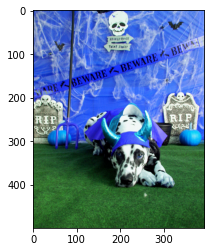

In [8]:
train_image_path = '/aiffel/aiffel/workplace/Aiffel_Quest/Main_Quest_2/huggingface/datasets/train/image/'
for i in range(len(train_data['image'])):
    encoded_img = np.frombuffer(train_data['image'][i]['bytes'], dtype = np.uint8)
    img_read = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
    plt.imshow(img_read)
    cv2.imwrite(train_image_path + f'{i}.jpg',img_read)

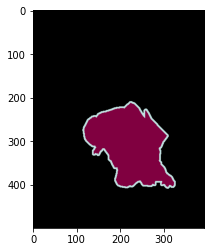

In [9]:
train_mask_path = '/aiffel/aiffel/workplace/Aiffel_Quest/Main_Quest_2/huggingface/datasets/train/mask/'
for i in range(len(train_data['mask'])):
    encoded_img = np.frombuffer(train_data['mask'][i]['bytes'], dtype = np.uint8)
    img_read = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
    plt.imshow(img_read)
    cv2.imwrite(train_mask_path + f'{i}.jpg',img_read)

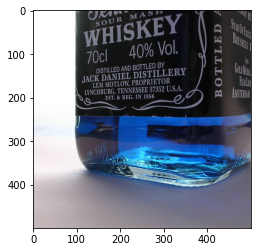

In [10]:
test_image_path = '/aiffel/aiffel/workplace/Aiffel_Quest/Main_Quest_2/huggingface/datasets/test/image/'
for i in range(len(test_data['image'])):
    encoded_img = np.frombuffer(test_data['image'][i]['bytes'], dtype = np.uint8)
    img_read = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
    plt.imshow(img_read)
    cv2.imwrite(test_image_path + f'{i}.jpg',img_read)

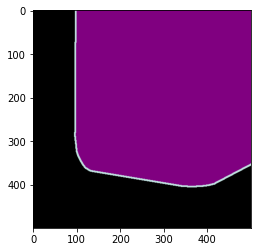

In [11]:
test_mask_path = '/aiffel/aiffel/workplace/Aiffel_Quest/Main_Quest_2/huggingface/datasets/test/mask/'
for i in range(len(test_data['mask'])):
    encoded_img = np.frombuffer(test_data['mask'][i]['bytes'], dtype = np.uint8)
    img_read = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
    plt.imshow(img_read)
    cv2.imwrite(test_mask_path + f'test_mask{i}.jpg',img_read)

In [13]:
print("~~")

~~


In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization, ReLU
from tensorflow.keras.models import Model


def unet(input_shape, num_classes):
    inputs = Input(input_shape)
    
    # Encoder 부분
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # 중앙 부분
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    
    # Decoder 부분
    up4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    
    up5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    merge5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)
    
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv5)
    
    model = Model(inputs, outputs)
    return model    

In [31]:
input_shape = (256, 256, 3)
num_classes = 2
model = unet(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, to_categorical(y_train), epochs=10, batch_size=3, validation_data=(x_test, to_categorical(y_test)))

NameError: name 'to_categorical' is not defined